In [120]:
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
import numpy as np
import datetime
import time

import random
import math
from matplotlib import pyplot as plt

In [132]:
#path = r"""F:\Research\Problem sets\Coloring\myciel4.col.txt"""
# path = r"""F:\Research\Problem sets\Coloring\Instances\DSJR500.5.col"""
# path = r"""F:\Research\Problem sets\Max Clique\DIMACS_all_ascii\c-fat500-2.clq""" # needs investigation
#path = r"""E:\Downloads\all-instaces.tar\1-FullIns_5.col"""

p_start_t = time.time()

INSTANCES_PATH = r"""F:\Research\Problem sets\Max Clique\DIMACS_all_ascii"""
OUT_LP_PATH = r"""F:\Research\Problem sets\Coloring\CP\OutputLP"""
SOLVER_LOG_PATH = r"""F:\Research\Problem sets\Coloring\CP\SolverLog"""

instance_name = "c-fat200-5"  #str(sys.argv[1])

filename = instance_name + r""".clq"""
# MAX_TIME_LIMIT_SECS = int(sys.argv[2]) #10
path = INSTANCES_PATH + '\\' + filename
print(instance_name)

#assert(PRE_PROCESS == help_with_bounds)

f = open(path, "r")
input = f.read()
f.close()
#print(input)
words = input.split()
for idx, word in enumerate(words):
    if word == 'p':
        break

parse1 = [int(i) for i in words[idx + 2:] if i != 'e']

num_v = parse1[0]
num_e = parse1[1]
parse1 = parse1[2:]

parse2 = []
for i in range(len(parse1) // 2):
    parse2.append((parse1[2 * i], parse1[2 * i + 1]))

c-fat200-5


In [146]:
graph = nx.Graph()
graph.add_nodes_from(range(1, num_v + 1))
graph.add_edges_from(parse2)
print(f"Number of nodes: {len(graph.nodes)}")
print(f"Number of edges: {len(graph.edges)}")

Number of nodes: 200
Number of edges: 8473


In [147]:
I = list(nx.find_cliques(nx.complement(graph)))

In [148]:
# Adding variables
m = gp.Model('Clique')
isBIP = False
var_type = (GRB.BINARY if isBIP == True else GRB.CONTINUOUS)

x = m.addVars(graph.nodes, vtype=var_type, lb=0, ub=1, name='x')

m.setObjective(x.sum(), GRB.MAXIMIZE)


for i in range(len(I)):
    # generate a max ind set containing node i
    ind_set = I[i]
    m.addConstr(
        gp.quicksum(x[i] for i in ind_set) <= 1
    )
#"""    
#m.addConstrs(x[i] + x[j] <= 1 for (i,j) in nx.complement(graph).edges)    

In [149]:
m.optimize()

Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (win64)
Optimize a model with 163212 rows, 200 columns and 489636 nonzeros
Model fingerprint: 0xd739528a
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.14s
Presolved: 200 rows, 163412 columns, 489836 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0000000e+02   0.000000e+00   7.308000e+03      0s
  163218    6.6666667e+01   0.000000e+00   0.000000e+00      2s

Solved in 163218 iterations and 1.97 seconds
Optimal objective  6.666666667e+01


In [150]:
# Adding variables
m = gp.Model('Clique')
isBIP = False
var_type = (GRB.BINARY if isBIP == True else GRB.CONTINUOUS)

x = m.addVars(graph.nodes, vtype=var_type, lb=0, ub=1, name='x')

m.setObjective(x.sum(), GRB.MAXIMIZE)

ind_sets = []
for i in graph.nodes:
    # generate a max ind set containing node i
    ind_set = nx.maximal_independent_set(graph, [i])
    ind_sets.append(ind_set)
    m.addConstr(
        gp.quicksum(x[i] for i in ind_set) <= 1
    )

In [151]:
sub = gp.Model('CGSP')
isBIP = True
var_type = (GRB.BINARY if isBIP == True else GRB.CONTINUOUS)

y = sub.addVars(graph.nodes, vtype=var_type, lb=0, ub=1, obj=1, name='y')

sub.addConstrs(y[i] + y[j] <= 1 for (i,j) in graph.edges)

sub.ModelSense = GRB.MAXIMIZE
#m.setObjective(y.sum(), GRB.MAXIMIZE)

In [152]:

m.reset()
sub.reset()
sub.Params.TimeLimit = 2
#sub.Params.Cutoff = 1
#sub.Params.mipFocus = 0
#sub.Params.ConcurrentMIP = 1
sub.Params.Heuristics = 1
sub.resetParams()
m.setParam('OutputFlag', 0)
sub.setParam('OutputFlag', 0)

Discarded solution information
Discarded solution information
Changed value of parameter TimeLimit to 2.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter Heuristics to 1.0
   Prev: 0.05  Min: 0.0  Max: 1.0  Default: 0.05
Reset all parameters


In [153]:
resolve = True
count = 0

In [154]:
upper_bound_list = []
reduced_cost_list = []
while resolve:
    count += 1
    m.update()
    m.optimize()
    upper_bound_list.append(m.objVal)
    print(m.objVal)
    weights = np.array(m.getAttr(GRB.Attr.X))
    #print(weights)
    #sub.reset()
    y = sub.getVars()
    for i in range(len(y)):
        y[i-1].setAttr('obj', weights[i-1])
    #sub.reset()
    sub.optimize()
    print(sub.objVal)
    reduced_cost_list.append(sub.ObjVal)
    if sub.objVal - 1 > 1e-4:
        # adding row
        new_row = np.array(sub.getAttr(GRB.Attr.X))
        new_ind_set = np.where(new_row > 0)[0] + 1
        #print(new_ind_set)
        
        x = m.getVars()
        m.addConstr(
            gp.quicksum(x[i-1] for i in new_ind_set) <= 1
        )
        m.update()
    else:
        #assert(1==0)
        print("LP Optimal")
        resolve = False
print(m.ObjVal)

78.3
3.0
78.3
3.0
76.76923076923079
3.0
76.33333333333337
3.0
76.00602409638554
3.0
75.76923076923077
3.0
75.46052631578945
3.0
74.39285714285715
3.0
74.23287671232879
3.0
73.39353233830845
3.0
72.68092105263155
3.0
71.47713120034356
2.7610049388018036
70.91810132808659
2.71947860304968
70.14315086518849
2.6416540561879076
69.57462589459988
2.8683409238776836
68.8600374064838
2.767456359102245
68.50290303326278
2.8069347224483154
68.10755705577107
2.626858783817825
67.90514081358964
2.6088141445593696
67.64526648773003
2.7051476226993874
67.50318787010836
2.455839220236224
67.39344090867273
2.513816257181106
67.2727656134678
2.5712695790719193
67.22927058450017
2.507089601735174
67.10751324225201
2.0218377671626944
67.03160933311945
2.289819723868564
66.86825612232458
2.318061228100854
66.7394696438796
2.070599798327609
66.66666666666664
1.3333333333333302
66.66666666666667
1.0
LP Optimal
66.66666666666667


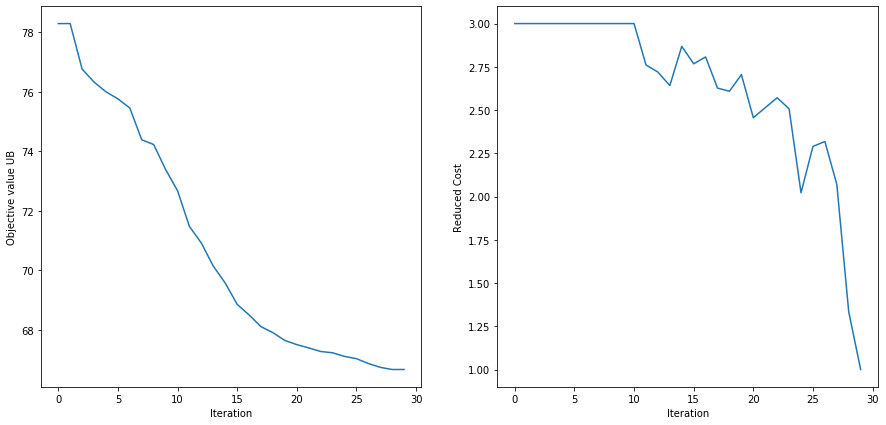

In [156]:
#print(upper_bound_list)
#reduced_cost_list
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ax1.plot(upper_bound_list)
ax1.set_ylabel('Objective value UB')
ax1.set_xlabel('Iteration')
#ax1.set_title('')
ax2.plot(reduced_cost_list)
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Reduced Cost')
#ax2.set_title('')
plt.show()

In [157]:
m.printStats()


Statistics for model Clique :
  Linear constraint matrix    : 229 Constrs, 200 Vars, 687 NZs
  Matrix coefficient range    : [ 1, 1 ]
  Objective coefficient range : [ 1, 1 ]
  Variable bound range        : [ 1, 1 ]
  RHS coefficient range       : [ 1, 1 ]
